# **Swarm Robotics Competitions**

### 2021/2022      

## A. Pedro Aguiar
<pedro.aguiar@fe.up.pt>
<br>

<br> FEUP Nov. 2021


---



**Initial setup:**
To run this notebook in *colab* you need to go to the colab pallete (left)-> file-> upload to session storage, and select the file **aux_file.py** that is in the same folder of this file.


# Swarm Marathon Competition


**Goal:** Collect a set of resources at positions $R_i$, $i=1, \ldots M$, and drop them at the warehouse (green border in the plot) within a fixed period of time $T$.

**Specifications:**
-  The fleet is composed by 5 drones.
- Drone 1 is the leader and has access to its global position $\xi_1$.
-  All the other drones *only* have access to the relative position $\xi_{ij}$ with respect to the other drones, if they are close enough to them (maximum range of MAX_RANGE).  
Example: Suppose that drone 1 and 3 are the only ones that are close to drone 2, then 
drone 2 has access to the relative position $\xi_{21}=\xi_2-\xi_1$ and $\xi_{23}=\xi_2-\xi_3$, and the others are set to zero $\xi_{24}=\xi_{25}=0$. 
- All drones have access to the closest distance and angle (direction) of the nearest obstacle, that is, $d_{io}$ and $\theta_{io}$.
- The maximum linear velocities (input) in $x$ and $y$ directions is $1\,m/s$, that is, $-1\le u_x, u_y \le 1$.
- The resources can only be picked and transported with two drones. Once they are carrying a resource, they cannot carry a second resource, and they should be no more than MAX_R_DIS apart of each other, otherwise it is considered that the resource is lost. 
- The drones cannot collide with each other, walls, and obstacles. In case of collision, the drone that collided stop and you do not have access to it. If it was transporting a resource, the resource returns to its initial position.

**Scores:**
- The times of picking the resources and dropping in the warehouse are saved. If the drones lost the resource, the time will be reseted.

- Wins the one that returned the maximum number of resources at the warehouse in less time.

**Parameters of this scenario:**
- Range of communication to obtain the relative position: MAX_RANGE = $5\,m$
- Maximum distance between 2 drones that they can be to pick a resource: MAX_R_PICK = $1\,m$
- Maximum distance between 2 drones that they can be to transport a resource: MAX_R_DIS = $3\,m$
- Initial configuration of the drones: 5-4-1-2-3 with same position in $y=-8\,m$ and in $x$ of $-2\,m, -1\,m, 0\,m, 1\,m, 2\,m$, respectively.
---



---
# **Scenario Task 2:** Two Resources $R_1$ and $R_2$ and no obstacles


You can include here the formulas used to compute $u_i$, $i=1, \ldots, 5$, that is
$$
u_1 = \ldots
$$ 

In [30]:
def my_swarm_control_law(t, R1, R2, R1_caught, R2_caught, R1_at_warehouse, R2_at_warehouse, \
                         d1o, angle1, d2o, angle2, d3o, angle3, d4o, angle4, d5o, angle5, \
                         state1, xi12, xi13, xi14, xi15, xi21, xi23, xi24, xi25, \
                         xi31, xi32, xi34, xi35, xi41, xi42, xi43, xi45, xi51, xi52, xi53, xi54):
###################################################################################################
##                                                                                               ##
##                                      Your code starts here                                    ##
##                                                                                               ##
## Grupo  8                                                                                      ##
## 202007865, Nuno Pereira                                                                       ##
## 202008052, Fábio Morais                                                                       ##
## 202004646, Francisco Prada                                                                    ##
## 202004714, Pedro Nunes                                                                        ##
## 202006056, Bernardo Campos                                                                    ##
###################################################################################################
# Here goes the list of variables that you can use in this part: 
# time: t
# Resource positions: R1, R2
# Boolean variables that indicate if the Resource is with a pair of drones: R1_caught, R2_caught
# Boolean variables that indicate if the Resource was delivered at the warehouse: R1_at_warehouse, R2_at_warehouse
# distances and angles to the nearest obstacle: d1o, angle1, d2o, angle2, ...
# position of drone 1: state1
# relative positions: xi12, xi13, xi14, xi15, xi21, xi23, xi24, xi25, ...
# note that the relative positions are set to zero when its norm is bigger than MAX_RANGE

    # My parameters
    
    kx, ky = 1, 1
    K = np.diag([kx,ky])
    c = 5
    Ko_init = 3*np.diag([1, 1])

    b12 = [-1.0, 0.0]
    b23 = [-0.5, 0.0]
    b14 = [1.0, 0.0]
    b45 = [1.0, 0.0]

    xid = (R1[0] - 1.5, R1[1])
    dot_xid = (0, 0)

    # Control law
    if R1_caught == False and R1_at_warehouse == False:
        print("I'm steering to R1")
        xid = (R1[0] - 1.5, R1[1])
    elif R2_caught == False and R2_at_warehouse == False:
        print("I'm steering to R2")
        xid = (R2[0], R2[1] - 1.0)

    if R1_caught and R2_caught: 
        print("I'm steering to the warehouse")
        xid = (-7.5, -7.5)

    if R1_at_warehouse or R2_at_warehouse: 
        print("One is R is delivered, there is still one to deliver...")

    if R1_at_warehouse and R2_at_warehouse: 
        print("I'm done! with t=", t)
    

    # Drone 1 - Leader
    u_control1 = - K @ (state1 - xid) + dot_xid

    # Drone 2 

    u_control2 = - K @ ( (xi21+b12) ) \
    + 1/(np.linalg.norm(xi21)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(xi21)**2) @ xi21 \
    + 1/(np.linalg.norm(xi23)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(xi23)**2) @ xi23 \
    + 1/(np.linalg.norm(xi24)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(xi24)**2) @ xi24 \
    + 1/(np.linalg.norm(xi25)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(xi25)**2) @ xi25 \
    - 1/(d2o+.1)*Ko_init*np.exp(-c*d2o**2) @ ( np.cos(angle2), np.sin(angle2) )

    # Drone 3
    u_control3 = - K @ ( (xi32+b23) ) \
    + 1/(np.linalg.norm(xi31)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(xi31)**2) @ xi31 \
    + 1/(np.linalg.norm(xi32)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(xi32)**2) @ xi32 \
    + 1/(np.linalg.norm(xi34)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(xi34)**2) @ xi34 \
    + 1/(np.linalg.norm(xi35)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(xi35)**2) @ xi35 \
    - 1/(d3o+.1)*Ko_init*np.exp(-c*d3o**2) @ ( np.cos(angle3), np.sin(angle3) )

    # Drone 4
 
    u_control4 = - K @ ( (xi41+b14) ) \
    + 1/(np.linalg.norm(xi41)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(xi41)**2) @ xi41 \
    + 1/(np.linalg.norm(xi42)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(xi42)**2) @ xi42 \
    + 1/(np.linalg.norm(xi43)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(xi43)**2) @ xi43 \
    + 1/(np.linalg.norm(xi45)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(xi45)**2) @ xi45 \
    - 1/(d4o+.1)*Ko_init*np.exp(-c*d4o**2) @ ( np.cos(angle4), np.sin(angle4) )

    # Drone 5

    u_control5 = - K @ ( (xi54+b45) ) \
    + 1/(np.linalg.norm(xi51)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(xi51)**2) @ xi51 \
    + 1/(np.linalg.norm(xi52)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(xi52)**2) @ xi52 \
    + 1/(np.linalg.norm(xi53)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(xi53)**2) @ xi53 \
    + 1/(np.linalg.norm(xi54)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(xi54)**2) @ xi54 \
    - 1/(d5o+.1)*Ko_init*np.exp(-c*d5o**2) @ ( np.cos(angle5), np.sin(angle5) )

    return u_control1, u_control2, u_control3, u_control4, u_control5
###################################################################################################
##                                                                                               ##
##                              End of your code section, do not edit the next part              ##
##                                                                                               ##
###################################################################################################

In [31]:
import math
import numpy as np
from aux_file import Integrator, Line, Ellipse, World, ConvexPolygon, check_collisions, update_relat_position, proximity, closest_drones, R_warehouse_check

# Parameters of range
MAX_RANGE = 5
MAX_R_PICK = 1
MAX_R_DIS = 3

# World arena
arena = ConvexPolygon([[ 10.0, -10.0 ],
                       [ 10.0, 10.0 ],
                       [ -10.0, 10.0 ],
                       [ -10.0, -10.0]])

# World obstacles
#obs1 = Ellipse(center = [7.5, -2.5], angle = np.radians(15.0), axes = [2.0, 1.5])

# Resource
initial_resource = {1: [7.5,5], 2: [-7.5,7.5]}
resource = {1: [7.5,5], 2: [-7.5,7.5]}  # keep track of the positions of the resources
num_R = 2
R1_caught = False
R2_caught = False

# Define world
world = World(arena)
#world.add_obstacle(obs1)

# Drones 
initial_state1 = [0.0, -8.0]
initial_control1 = [0.0, 0.0]
robot1 = Integrator(initial_state1, initial_control1)
initial_state2 = [1.0, -8.0]
initial_control2 = [0.0, 0.0]
robot2 = Integrator(initial_state2, initial_control2)
initial_state3 = [2.0, -8.0]
initial_control3 = [0.0, 0.0]
robot3 = Integrator(initial_state3, initial_control3)
initial_state4 = [-1.0, -8.0]
initial_control4 = [0.0, 0.0]
robot4 = Integrator(initial_state4, initial_control4)
initial_state5 = [-2.0, -8.0]
initial_control5 = [0.0, 0.0]
robot5 = Integrator(initial_state5, initial_control5)

# Time of simulation
sim_time = 60
dt = 0.1

time = []
ux1, uy1, ux2, uy2, ux3, uy3, ux4, uy4, ux5, uy5 = [], [], [], [], [], [], [], [], [], []
x1, y1, x2, y2, x3, y3, x4, y4, x5, y5  = [], [], [], [], [], [], [], [], [], []

#Closest point
cpx1, cpy1, cpx2, cpy2, cpx3, cpy3, cpx4, cpy4, cpx5, cpy5 = [], [], [], [], [], [], [], [], [], []

# Configuration Matrices 
do = np.zeros((5)) # Distance to obstacle
d_mtx = np.zeros((5)) # Damaged matrix
R_delivered = np.zeros((2)) # Indicates if Resource was delivered at the warehouse
w_R_mtx = np.zeros((5)) # Matrix that tells if a pair of drones caught some R
time_score = np.array([999.9,999.9,999.9,999.9]) # 0 - caught R_1, 1 - caught R_2, 2 - drop R_1 in warehouse, 3 - drop R_2 in warehouse
position_mtx = np.zeros((5,5)) # matrix that indicates which drones are near


# Here goes the main loop
for t in np.around(np.arange(int(sim_time/dt))*dt,2):

    # Time
    time.append(t)

    # Get the state
    state1 = robot1.get_state()
    state2 = robot2.get_state()
    state3 = robot3.get_state()
    state4 = robot4.get_state()
    state5 = robot5.get_state()
    
    # Relative positions
    xi12, xi13, xi14, xi15 = state1 - state2, state1 - state3, state1 - state4, state1 - state5
    xi21, xi23, xi24, xi25 = state2 - state1, state2 - state3, state2 - state4, state2 - state5
    xi31, xi32, xi34, xi35 = state3 - state1, state3 - state2, state3 - state4, state3 - state5
    xi41, xi42, xi43, xi45 = state4 - state1, state4 - state2, state4 - state3, state4 - state5
    xi51, xi52, xi53, xi54 = state5 - state1, state5 - state2, state5 - state3, state5 - state4
    #xi_all = (xi21, xi23, xi24, xi25, xi31, xi32, xi34, xi35, xi41, xi42, xi43, xi45, xi51, xi52, xi53, xi54)
    xi_all = (xi21, xi23, xi24, xi25, xi31, xi32, xi34, xi35, xi41, xi42, xi43, xi45, xi51, xi52, xi53, xi54, xi12, xi13, xi14, xi15)
    position_mtx, xi_all = update_relat_position(position_mtx, xi_all, MAX_RANGE)
    #xi21, xi23, xi24, xi25, xi31, xi32, xi34, xi35, xi41, xi42, xi43, xi45, xi51, xi52, xi53, xi54 = xi_all[0], xi_all[1], xi_all[2], xi_all[3], xi_all[4], xi_all[5], xi_all[6], xi_all[7], xi_all[8], xi_all[9], xi_all[10], xi_all[11], xi_all[12], xi_all[13], xi_all[14], xi_all[15]
    xi21, xi23, xi24, xi25, xi31, xi32, xi34, xi35, xi41, xi42, xi43, xi45, xi51, xi52, xi53, xi54, xi12, xi13, xi14, xi15 = xi_all[0], xi_all[1], xi_all[2], xi_all[3], xi_all[4], xi_all[5], xi_all[6], xi_all[7], xi_all[8], xi_all[9], xi_all[10], xi_all[11], xi_all[12], xi_all[13], xi_all[14], xi_all[15], xi_all[16], xi_all[17], xi_all[18], xi_all[19]
 
    # Get the closest point of obstacles of each drone
    closest_pt, do[0] = world.compute_closest(state1) 
    d1o = do[0]
    angle1 = np.arctan2(closest_pt[1]-state1[1],closest_pt[0]-state1[0])
    cpx1.append(closest_pt[0])
    cpy1.append(closest_pt[1])
    
    closest_pt, do[1] = world.compute_closest(state2) 
    d2o = do[1]
    angle2 = np.arctan2(closest_pt[1]-state2[1],closest_pt[0]-state2[0])
    cpx2.append(closest_pt[0])
    cpy2.append(closest_pt[1])
    
    closest_pt, do[2] = world.compute_closest(state3) 
    d3o = do[2]
    angle3 = np.arctan2(closest_pt[1]-state3[1],closest_pt[0]-state3[0])
    cpx3.append(closest_pt[0])
    cpy3.append(closest_pt[1])

    closest_pt, do[3] = world.compute_closest(state4) # closest point and distance to that point
    d4o = do[3]
    angle4 = np.arctan2(closest_pt[1]-state4[1],closest_pt[0]-state4[0])
    cpx4.append(closest_pt[0])
    cpy4.append(closest_pt[1])

    closest_pt, do[4] = world.compute_closest(state5) # closest point and distance to that point
    d5o = do[4]
    angle5 = np.arctan2(closest_pt[1]-state5[1],closest_pt[0]-state5[0])
    cpx5.append(closest_pt[0])
    cpy5.append(closest_pt[1])

    #Resources positions
    R1=resource[1]
    R2=resource[2]

    R1_at_warehouse = R_delivered[0]
    R2_at_warehouse = R_delivered[1]

    ######## Calling the control law for each drone
    u_control1, u_control2, u_control3, u_control4, u_control5 = my_swarm_control_law(t, R1, R2, R1_caught, R2_caught, R1_at_warehouse, R2_at_warehouse, \
                                                                                      d1o, angle1, d2o, angle2, d3o, angle3, d4o, angle4, d5o, angle5, \
                                                                                      state1, xi12, xi13, xi14, xi15, xi21, xi23, xi24, xi25, \
                                                                                      xi31, xi32, xi34, xi35, xi41, xi42, xi43, xi45, xi51, xi52, xi53, xi54)
    ########

    xi = (xi21, xi31, xi41, xi51)
    points_vec = np.array([state1,state2,state3,state4,state5])

    # Check collisions
    d_mtx, w_R_mtx, time_score = check_collisions(points_vec, d_mtx, w_R_mtx, do, xi, time_score)
    
    # compute a proximity table to check what are the drones that are closer to the Resources
    prox_mtx_1, prox_mtx_2 = proximity(points_vec, resource, num_R)

    # Send actuation commands
    if d_mtx[0]==1:
        u_control1=[0,0]
        u_control2=[0,0]
        u_control3=[0,0]
        u_control4=[0,0]
        u_control5=[0,0]
        prox_mtx_1[0] = 99
        prox_mtx_2[0] = 99    
        prox_mtx_1[1] = 99
        prox_mtx_2[1] = 99        
        prox_mtx_1[2] = 99
        prox_mtx_2[2] = 99        
        prox_mtx_1[3] = 99
        prox_mtx_2[3] = 99        
        prox_mtx_1[4] = 99
        prox_mtx_2[4] = 99        

    if d_mtx[1]==1:
        u_control2=[0,0]
        prox_mtx_1[1] = 99
        prox_mtx_2[1] = 99

    if d_mtx[2]==1:
        u_control3=[0,0]
        prox_mtx_1[2] = 99
        prox_mtx_2[2] = 99

    if d_mtx[3]==1:
        u_control4=[0,0]
        prox_mtx_1[3] = 99
        prox_mtx_2[3] = 99

    if d_mtx[4]==1:
        u_control5=[0,0]
        prox_mtx_1[4] = 99
        prox_mtx_2[4] = 99
    
    # Find the closest drones to the Resource
    w_R_mtx, time_score = closest_drones(prox_mtx_1, prox_mtx_2, w_R_mtx, time_score, t, R_delivered, num_R, MAX_R_PICK)

    if 1 in w_R_mtx:
        R1_caught = True
    else:
        R1_caught = False
    
    if 2 in w_R_mtx:
        R2_caught = True
    else:
        R2_caught = False
    
    # Saturate the control inputs between -1 and 1 
    u_control1 = np.clip(u_control1, -1, 1)
    u_control2 = np.clip(u_control2, -1, 1)
    u_control3 = np.clip(u_control3, -1, 1)
    u_control4 = np.clip(u_control4, -1, 1)
    u_control5 = np.clip(u_control5, -1, 1)

    robot1.set_control(u_control1)
    robot1.actuate(dt)
    robot2.set_control(u_control2)
    robot2.actuate(dt)
    robot3.set_control(u_control3)
    robot3.actuate(dt)
    robot4.set_control(u_control4)
    robot4.actuate(dt)
    robot5.set_control(u_control5)
    robot5.actuate(dt)    
    
    ux1.append(u_control1[0])
    uy1.append(u_control1[1])
    x1.append(state1[0])
    y1.append(state1[1])
    ux2.append(u_control2[0])
    uy2.append(u_control2[1])
    x2.append(state2[0])
    y2.append(state2[1])
    ux3.append(u_control3[0])
    uy3.append(u_control3[1])
    x3.append(state3[0])
    y3.append(state3[1])
    ux4.append(u_control4[0])
    uy4.append(u_control4[1])
    x4.append(state4[0])
    y4.append(state4[1])
    ux5.append(u_control5[0])
    uy5.append(u_control5[1])
    x5.append(state5[0])
    y5.append(state5[1])

    w_R_mtx, time_score, R_delivered = R_warehouse_check(w_R_mtx, points_vec, resource, time_score, t, R_delivered, MAX_R_DIS)
   

I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering to R1
I'm steering

Results:
Time of picking Resource 1: 14.4
Time of picking resource 2: 28.6
Time of delivering Resource 1 at the warehouse: 42.3
Time of delivering Resource 2 at the warehouse: 42.3
Final score: 42.3


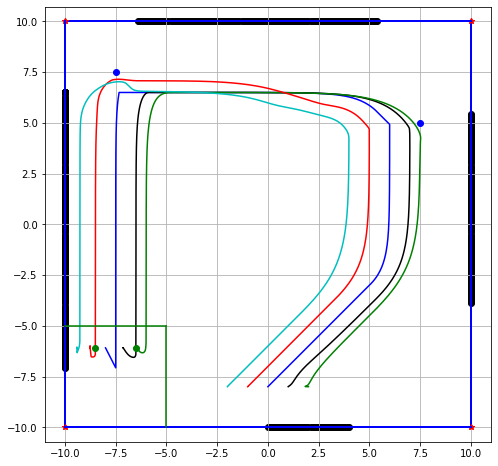

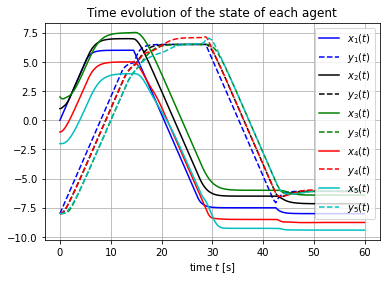

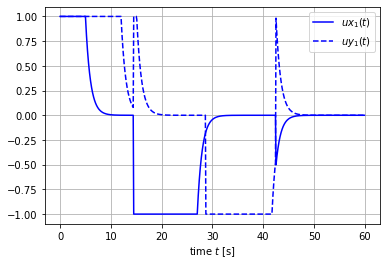

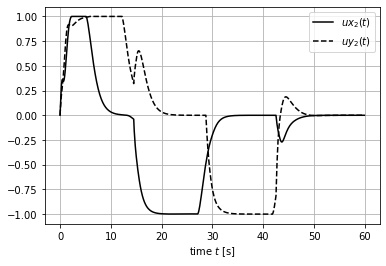

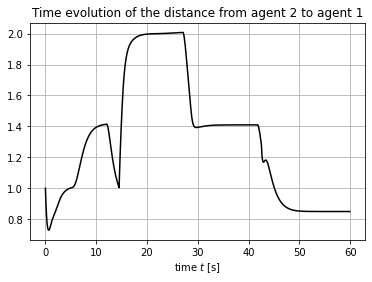

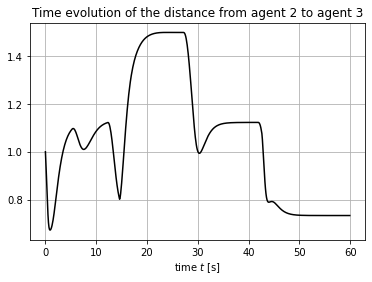

In [32]:
# Plot commands
%matplotlib inline 
#%matplotlib notebook

import matplotlib.pyplot as plt

#fig, ax = plt.subplots(figsize=(18,18))
fig, ax = plt.subplots(figsize=(8,8))

#plt.figure(figsize=(1,1))
ax.axis('equal')
xdim, ydim = 10, 10
plt.xlim(-xdim-1,xdim+1)
plt.ylim(-ydim-1,ydim+1)
plt.grid()

# Plots walls and obstacles
world.plot()

line1, = plt.plot(x1, y1, label='$x_1(t), y_1(t)$', color='b')
points_lidar = plt.scatter(cpx1, cpy1, label='$cpx_1(t), cpy_1(t)$', marker='o', color='k')
line2, = plt.plot(x2, y2, label='$x_2(t), y_2(t)$', color='k')
line3, = plt.plot(x3, y3, label='$x_3(t), y_3(t)$', color='g')
line4, = plt.plot(x4, y4, label='$x_4(t), y_4(t)$', color='r')
line5, = plt.plot(x5, y5, label='$x_5(t), y_5(t)$', color='c')
plt.plot((-10,-5),(-5,-5), color='g')
plt.plot((-5,-5),(-5,-10), color='g')

if R_delivered[0] == False:
    initial_resource1, = plt.plot(initial_resource[1][0], initial_resource[1][1], marker='o', color='r')
else:
    initial_resource1, = plt.plot(initial_resource[1][0], initial_resource[1][1], marker='o', color='b')
    final_resource1, = plt.plot(resource[1][0], resource[1][1], marker='o', color='g')

if num_R == 2:
    if R_delivered[1] == False:
        initial_resource2, = plt.plot(initial_resource[2][0], initial_resource[2][1], marker='o', color='r')
    else:
        initial_resource2, = plt.plot(initial_resource[2][0], initial_resource[2][1], marker='o', color='b')
        final_resource2, = plt.plot(resource[2][0], resource[2][1], marker='o', color='g')


if d_mtx[0] == 1:
    plt.plot(state1[0], state1[1], marker='*', color='y')
if d_mtx[1] == 1:
    plt.plot(state2[0], state2[1], marker='*', color='y')
if d_mtx[2] == 1:
    plt.plot(state3[0], state3[1], marker='*', color='y')
if d_mtx[3] == 1:
    plt.plot(state4[0], state4[1], marker='*', color='y')
if d_mtx[4] == 1:
    plt.plot(state5[0], state5[1], marker='*', color='y')


plt.figure()
plt.plot(time, x1, label='$x_1(t)$', color='b')
plt.plot(time, y1, label='$y_1(t)$', color='b', linestyle='dashed')
plt.plot(time, x2, label='$x_2(t)$', color='k')
plt.plot(time, y2, label='$y_2(t)$', color='k', linestyle='dashed')
plt.plot(time, x3, label='$x_3(t)$', color='g')
plt.plot(time, y3, label='$y_3(t)$', color='g', linestyle='dashed')
plt.plot(time, x4, label='$x_4(t)$', color='r')
plt.plot(time, y4, label='$y_4(t)$', color='r', linestyle='dashed')
plt.plot(time, x5, label='$x_5(t)$', color='c')
plt.plot(time, y5, label='$y_5(t)$', color='c', linestyle='dashed')
plt.xlabel('time $t$ [s]')
plt.legend()
plt.grid()
plt.title('Time evolution of the state of each agent');


plt.figure()
plt.plot(time, ux1, label='$ux_1(t)$', color='b')
plt.plot(time, uy1, label='$uy_1(t)$', color='b', linestyle='dashed')
plt.xlabel('time $t$ [s]')
plt.legend()
plt.grid()
plt.figure()
plt.plot(time, ux2, label='$ux_2(t)$', color='k')
plt.plot(time, uy2, label='$uy_2(t)$', color='k', linestyle='dashed')
plt.xlabel('time $t$ [s]')
plt.legend()
plt.grid()

plt.figure()
dist21=zip(x1,y1,x2,y2)
dist21 = [np.sqrt((x1-x2)**2+(y1-y2)**2) for (x1,y1,x2,y2) in dist21]
plt.plot(time, dist21, label='$x_1-x_2$', color='k')
plt.grid()
plt.title('Time evolution of the distance from agent 2 to agent 1');
plt.xlabel('time $t$ [s]');

plt.figure()
dist23=zip(x2,y2,x3,y3)
dist23 = [np.sqrt((x2-x3)**2+(y2-y3)**2) for (x2,y2,x3,y3) in dist23]
plt.plot(time, dist23, label='$x_2-x_3$', color='k')
plt.grid()
plt.title('Time evolution of the distance from agent 2 to agent 3');
plt.xlabel('time $t$ [s]');

print("Results:")
#time_score: 0 - caught R_1, 1 - caught R_2, 2 - drop R_1 in warehouse, 3 - drop R_2 in warehouse
print('Time of picking Resource 1:',time_score[0])
print('Time of picking resource 2:',time_score[1])
print('Time of delivering Resource 1 at the warehouse:',time_score[2])
print('Time of delivering Resource 2 at the warehouse:',time_score[3])
print('Final score:',max(time_score[2],time_score[3]))



In [29]:
from matplotlib import animation

fnum = len(x1)
#print(fnum)
# animation function. This is called sequentially
def drawframe(n):
    #print(n)
    #print('time:',time_score[0])
    if time_score[2]!=999.9:
        if n < time_score[0]*10:
            initial_resource1.set_data(initial_resource[1][0], initial_resource[1][1])
            initial_resource1.set_color('r')
        else: 
            initial_resource1.set_color('b')
    if time_score[2]!=999.9:
        if n < time_score[1]*10:
            initial_resource2.set_data(initial_resource[2][0], initial_resource[2][1])
            initial_resource2.set_color('r')
        else: 
            initial_resource2.set_color('b')
    
    if time_score[2]!=999.9:
        if n < time_score[2]*10:
            final_resource1.set_data(resource[1][0], resource[1][1])
            final_resource1.set_color("w")
            final_resource1.set_alpha(0.0)
        else:
            final_resource1.set_data(resource[1][0], resource[1][1])
            final_resource1.set_color("g")
            final_resource1.set_alpha(1.0)
    
    if time_score[2]!=999.9:
        if n < time_score[3]*10:
            final_resource2.set_data(resource[2][0], resource[2][1])
            final_resource2.set_color("w")
            final_resource2.set_alpha(0.0)
        else:
            final_resource2.set_data(resource[2][0], resource[2][1])
            final_resource2.set_color("g")
            final_resource2.set_alpha(1.0)
    
    line1.set_data(x1[0:n], y1[0:n])
    line2.set_data(x2[0:n], y2[0:n])
    line3.set_data(x3[0:n], y3[0:n])
    line4.set_data(x4[0:n], y4[0:n])
    line5.set_data(x5[0:n], y5[0:n])
    points_lidar.set_offsets(np.c_[cpx1[0:n], cpy1[0:n]])
    return (line1,line2)


# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=fnum, interval=15, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())